### **Import Library**

In [1]:
# ===== Torch Library ===== #
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

from torcheval.metrics import R2Score

from torchsummary import summary

# ===== etc ===== #
import numpy as np
import pandas as pd

import copy
from copy import deepcopy

import argparse
import matplotlib.pyplot as plt

import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### **Dataset**

In [2]:
def normalize(a):
    return (a-a.min(dim=0)[0])/(a.max(dim=0)[0]-a.min(dim=0)[0])


sleep_dir = './Dataset/user_sleep_2020.csv'

modal_category = [
    'startDt', 'endDt', 'lastUpdate',
    'wakeupduration', 'wakeupcount', 'durationtosleep', 'durationtowakeup',
    'lightsleepduration', 'deepsleepduration', 'remsleepduration',
    'hr_average', 'hr_min', 'hr_max', 'rr_average', 'rr_min', 'rr_max', 'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount'
]
len_modals = [3, 4, 3, 9]


sleep_df = pd.read_csv(sleep_dir)
sleep_df[['startDt', 'endDt', 'lastUpdate']] = sleep_df[['startDt', 'endDt', 'lastUpdate']]/60


sleep_data, sleep_label = sleep_df.iloc[:,3:-1][modal_category], sleep_df.iloc[:,-1]

sleep_data = normalize(torch.Tensor(sleep_data.values).to(torch.float32))
sleep_label = torch.Tensor(sleep_label.values).to(torch.float32).unsqueeze(1)

rand_idx = torch.randperm(len(sleep_data))

sleep_data, sleep_label = sleep_data[rand_idx], sleep_label[rand_idx]
print(sleep_data.shape, sleep_label.shape)

in_dim, out_dim = sleep_data.shape[1], 1

torch.Size([615, 19]) torch.Size([615, 1])


In [3]:
dataset = torch.utils.data.TensorDataset(sleep_data, sleep_label)

dataset_size = len(dataset)
train_size = int(len(dataset) * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - (train_size + val_size)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### **Model**

In [4]:
class Embedding(nn.Module):
    def __init__(self, in_dim, emb_dim, n_layer):
        super(Embedding, self).__init__()

        self.in_dim = in_dim
        self.emb_dim = emb_dim
        self.n_layer = n_layer

        # ===== Create Linear Layers ===== #
        self.fc1 = nn.Linear(self.in_dim, self.emb_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.emb_dim, self.emb_dim))
            self.bns.append(nn.BatchNorm1d(self.emb_dim))

        self.fc2 = nn.Linear(self.emb_dim, self.emb_dim)

        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
        x = self.fc2(x)
        return x


for num_modal, len_modal in enumerate(len_modals):
    print(f"\n # ===== Embedding model {num_modal+1} ===== #")
    test_embedding = Embedding(len_modal, 50, 1).to(device)
    summary(test_embedding, (len_modal,))


 # ===== Embedding model 1 ===== #
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             200
              ReLU-2                   [-1, 50]               0
            Linear-3                   [-1, 50]           2,550
Total params: 2,750
Trainable params: 2,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------

 # ===== Embedding model 2 ===== #
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             250
              ReLU-2                   [-1, 50]               0
            Linear-3                 

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, use_bn, use_xavier):
        super(Net, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.use_bn = use_bn
        self.use_xavier = use_xavier


        # ===== Create Linear Layers ===== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn: self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)


        # ====== Create Activation Function ====== #
        if self.act == 'relu': self.act = nn.ReLU()
        elif self.act == 'leakyrelu': self.act = nn.LeakyReLU()
        elif self.act == 'tanh': self.act = nn.Tanh()
        elif self.act == 'sigmoid': self.act = nn.Sigmoid()
        else: raise ValueError('no valid activation function')


        # ====== Create Regularization Layer ======= #
        if self.use_xavier: self.xavier_init()


    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn==True: x = self.bns[i](x)
        x = self.fc2(x)
        return x


    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

test_model = Net(50, out_dim, 230, 2, 'relu', True, True).to(device) # arbitrary hidden_dim
summary(test_model, (50,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 230]          11,730
              ReLU-2                  [-1, 230]               0
            Linear-3                  [-1, 230]          53,130
              ReLU-4                  [-1, 230]               0
       BatchNorm1d-5                  [-1, 230]             460
            Linear-6                    [-1, 1]             231
Total params: 65,551
Trainable params: 65,551
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.25
Estimated Total Size (MB): 0.26
----------------------------------------------------------------


### **Training Functions**

In [6]:
def train(model, emb_list, partition, criterion, optimizer, metric, epoch, args): 
    train_loader = DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True)

    r_square, total = 0, 0
    train_loss = 0  

    model.train()
    for i in range(len(emb_list)):
        emb_list[i] = emb_list[i].train()

    for inputs, labels in iter(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() 
        
        embed_inputs, feat_num = 0, 0
        for num in range(len(len_modals)):
            masking_idx = torch.tile(torch.where(torch.empty(inputs.shape[0], 1).uniform_(0, 1) > args.threshold, 1.0, 0.0), (1,args.emb_dim)).to(device)

            col_inputs = inputs[:, feat_num:feat_num+len_modals[num]]
            embed_inputs += masking_idx*emb_list[num](col_inputs)
            feat_num += len_modals[num]
            
        outputs = model(embed_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        metric.update(outputs, labels)
        r_square += metric.compute().item()

    train_loss /= len(train_loader)
    train_accuracy = (r_square / len(train_loader)) * 100.0

    return model, emb_list, train_loss, train_accuracy


def validate(model, emb_list, partition, criterion, metric, args):
    val_loader = DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False)
    model.eval()
    for i in range(len(emb_list)):
        emb_list[i] = emb_list[i].eval()
        
    r_square, total = 0, 0
    loss =  0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        embed_inputs, feat_num = 0, 0
        for num in range(len(len_modals)):
            masking_idx = torch.tile(torch.where(torch.empty(inputs.shape[0], 1).uniform_(0, 1) > args.threshold, 1.0, 0.0), (1,args.emb_dim)).to(device)

            col_inputs = inputs[:, feat_num:feat_num+len_modals[num]]
            embed_inputs += masking_idx*emb_list[num](col_inputs)
            feat_num += len_modals[num]
            
        outputs = model(embed_inputs)
        loss += criterion(outputs, labels).item()
        metric.update(outputs, labels)
        r_square += metric.compute().item()

    val_loss = loss / len(val_loader)
    val_accuracy = (r_square / len(val_loader)) * 100.0
    
    return val_loss, val_accuracy


def test(model, emb_list, partition, metric, args):
    test_loader = DataLoader(partition['test'], batch_size=args.test_batch_size, shuffle=False)
    model.eval()
    for i in range(len(emb_list)):
        emb_list[i] = emb_list[i].eval()
        
    r_square, total = 0, 0 

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        embed_inputs, feat_num = 0, 0
        for num in range(len(len_modals)):
            masking_idx = torch.tile(torch.where(torch.empty(inputs.shape[0], 1).uniform_(0, 1) > args.threshold, 1.0, 0.0), (1,args.emb_dim)).to(device)

            col_inputs = inputs[:, feat_num:feat_num+len_modals[num]]
            embed_inputs += masking_idx*emb_list[num](col_inputs)
            feat_num += len_modals[num]
            
        outputs = model(embed_inputs)

        metric.update(outputs, labels)
        r_square += metric.compute().item()

    test_accuracy = (r_square / len(test_loader)) * 100.0
    
    return test_accuracy

In [7]:
def experiment(partition, args):
    model = Net(args.emb_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.use_bn, args.use_xavier).to(device)
    emb_list = [Embedding(len_modals[i], args.emb_dim, args.emb_n_layer).to(device) for i in range(len(len_modals))]

    emb_params = []
    for emb in emb_list:
        emb_params += list(emb.parameters())
    
    criterion = nn.MSELoss()
    metric = R2Score()
    
    if args.optim == 'SGD': optimizer = optim.SGD(list(model.parameters()) + emb_params, lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop': optimizer = optim.RMSprop(list(model.parameters()) + emb_params, lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam': optimizer = optim.Adam(list(model.parameters()) + emb_params, lr=args.lr, weight_decay=args.l2)
    else: raise ValueError('In-valid optimizer choice')

    if args.scheduler == 'ExponentialLR': scheduler = ExponentialLR(optimizer, gamma=0.5)
    elif args.scheduler == 'CosineAnnealingLR': scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
    elif args.scheduler == 'ReduceLROnPlateau': scheduler = ReduceLROnPlateau(optimizer, 'min')
    else: raise ValueError('In-valid scheduler choice')

    train_losses, train_acces = [], []
    val_losses, val_acces = [], []
    best_set = (0, 0)

    for epoch in range(args.epochs):
        model, emb_list, train_loss, train_acc = train(model, emb_list, partition, criterion, optimizer, metric, epoch, args)
        val_loss, val_acc = validate(model, emb_list, partition, criterion, metric, args)

        scheduler.step() if args.scheduler!='ReduceLROnPlateau' else scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acces.append(train_acc)
        val_acces.append(val_acc)

        if epoch%1000 == 0 or epoch==(args.epochs-1):
            print(f'[Epoch {epoch}]  Train Loss: {train_loss}  Train Acc: {train_acc:.2f}  Val Loss: {val_loss}  Val Acc: {val_acc:.2f}')
        

        # ===== early stopping ===== #
        if val_acc > best_set[0]: 
            best_set = (val_acc, epoch)
            torch.save(model.state_dict(), f"models/{args.exp_name}/[{args.threshold}, {args.emb_dim}, {args.emb_n_layer}, {args.hid_dim}, {args.n_layer}]model.pth")
            for i, emb in enumerate(emb_list):
                torch.save(emb.state_dict(), f"models/{args.exp_name}/[{args.threshold}, {args.emb_dim}, {args.emb_n_layer}, {args.hid_dim}, {args.n_layer}]embedding_{i}.pth")


    test_acc = test(model, emb_list, partition, metric, args) 
    print(f'Test Acc: {test_acc}')

    return train_losses, val_losses, train_acces, val_acces, best_set

In [8]:
def plot_loss(train_losses, val_losses, train_acces, val_acces):
    plt.figure(figsize=(8, 3))
    
    plt.subplot(1,2,1)
    plt.plot(train_losses, label = 'Train')
    plt.plot(val_losses, label = 'Val')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acces, label = 'Train')
    plt.plot(val_acces, label = 'Val')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

    plt.show()

#### **Experiments**

exp_name: Multi modal
lr: 0.004641588833612777
threshold: 0

[Epoch 0]  Train Loss: 3058.38037109375  Train Acc: -399.97  Val Loss: 3316.260986328125  Val Acc: -380.25
[Epoch 1000]  Train Loss: 22.23260658979416  Train Acc: 94.83  Val Loss: 14.530950546264648  Val Acc: 94.83
[Epoch 2000]  Train Loss: 19.161473393440247  Train Acc: 96.18  Val Loss: 14.735527038574219  Val Acc: 96.18
[Epoch 3000]  Train Loss: 12.919516324996948  Train Acc: 96.64  Val Loss: 14.796602249145508  Val Acc: 96.64
[Epoch 4000]  Train Loss: 35.31623339653015  Train Acc: 96.87  Val Loss: 15.045215606689453  Val Acc: 96.87
[Epoch 5000]  Train Loss: 14.79028207063675  Train Acc: 97.00  Val Loss: 14.755071640014648  Val Acc: 97.00
[Epoch 6000]  Train Loss: 15.731726169586182  Train Acc: 97.09  Val Loss: 14.66403865814209  Val Acc: 97.09
[Epoch 7000]  Train Loss: 22.929280042648315  Train Acc: 97.15  Val Loss: 14.914125442504883  Val Acc: 97.15
[Epoch 8000]  Train Loss: 20.96009910106659  Train Acc: 97.20  Val Loss: 

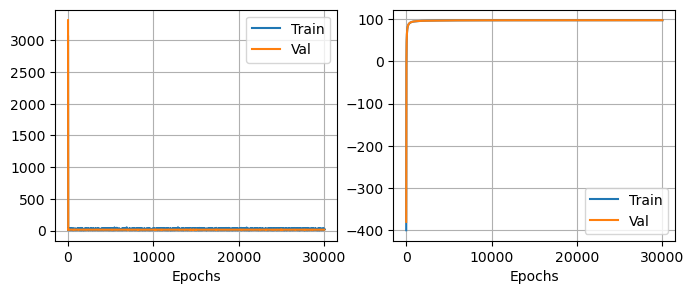

exp_name: ED/Multi modal
lr: 0.001
threshold: 0.2

[Epoch 0]  Train Loss: 3210.630340576172  Train Acc: -392.77  Val Loss: 3389.171875  Val Acc: -398.81
[Epoch 1000]  Train Loss: 72.73473024368286  Train Acc: 77.20  Val Loss: 20.4686279296875  Val Acc: 77.20
[Epoch 2000]  Train Loss: 64.27265191078186  Train Acc: 82.69  Val Loss: 138.91384887695312  Val Acc: 82.69
[Epoch 3000]  Train Loss: 72.14027833938599  Train Acc: 84.52  Val Loss: 78.91737365722656  Val Acc: 84.52
[Epoch 4000]  Train Loss: 73.49899864196777  Train Acc: 85.44  Val Loss: 54.747802734375  Val Acc: 85.44
[Epoch 5000]  Train Loss: 67.75127840042114  Train Acc: 86.01  Val Loss: 68.86443328857422  Val Acc: 86.01
[Epoch 6000]  Train Loss: 70.72305607795715  Train Acc: 86.38  Val Loss: 173.27601623535156  Val Acc: 86.38
[Epoch 7000]  Train Loss: 66.82807326316833  Train Acc: 86.66  Val Loss: 94.388427734375  Val Acc: 86.66
[Epoch 8000]  Train Loss: 64.93887758255005  Train Acc: 86.86  Val Loss: 91.13226318359375  Val Acc: 

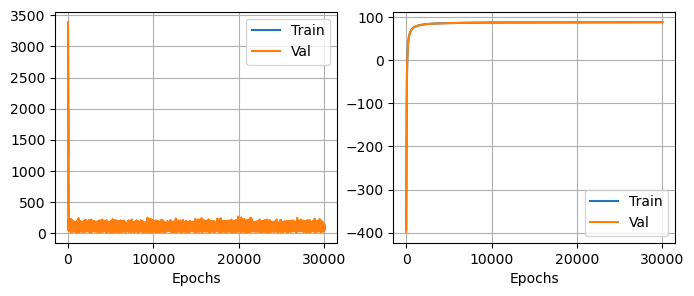

In [9]:
# Train Multi modal models (w/ ED & w/o ED)

seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = ""              ######  Variable 1  ######

# ====== Model Capacity ====== #
args.in_dim = in_dim
args.emb_dim = 50
args.emb_n_layer = 1

args.out_dim = out_dim
args.hid_dim = 230
args.act = 'relu'
args.n_layer = 2

# ====== Regularization ======= #
args.use_bn = True
args.l2 = 1e-06
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
args.scheduler = 'ReduceLROnPlateau'
args.lr = ""                    ######  Variable 2  ######

# ====== Training Params ====== #
args.epochs = 30000
args.train_batch_size = 64
args.test_batch_size = 64

args.threshold = 0              ######  Variable 3  ######

# ===== Name of Hyperparameters to tune ===== #
name_var1 = 'exp_name'
name_var2 = 'lr'
name_var3 = 'threshold'

# ===== Variable of Hyperparameters to tune ===== #
list_var1 = ['Multi modal', 'ED/Multi modal']
list_var2 = [0.004641588833612777, 0.001]
list_var3 = [0, 0.2]


# =========================  Experiments  ========================= #
partition = {'train':train_set, 'val':val_set, 'test':test_set}

for var1, var2, var3 in zip(list_var1, list_var2, list_var3):
    setattr(args, name_var1, var1)      # setattr means => args.exp_name = var1
    setattr(args, name_var2, var2)      # setattr means => args.lr = var2
    setattr(args, name_var3, var3)      # setattr means => args.threshold = var3

    print(f"{name_var1}: {var1}")
    print(f"{name_var2}: {var2}")
    print(f"{name_var3}: {var3}\n")

    train_losses, val_losses, train_acces, val_acces, best_set = experiment(partition, args)
    plot_loss(train_losses, val_losses, train_acces, val_acces)